# If the customer has default assigning all statements the value 1

In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
# Read training data 
df_train_x = pd.read_parquet('../data/train.parquet')
df_train_x.columns = df_train_x.columns.str.lower()
# Read training data labels
df_train_y = pd.read_csv('../data/train_labels.csv')
df_train_y.columns = df_train_y.columns.str.lower()
df_train_y = df_train_y.set_index('customer_id')

df_train_x = df_train_x.sort_values(['customer_id', 's_2'])
df_train = pd.merge(df_train_x, df_train_y, on='customer_id')
del (df_train_x)

In [3]:
df_train[df_train['customer_id']== '0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85'][['customer_id','s_2','target']]

,customer_id,s_2,target
104,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-03-15,1
105,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-04-14,1
106,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-05-15,1
107,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-06-14,1
108,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-07-15,1
109,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-08-15,1
110,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-09-14,1
111,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-10-14,1
112,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-11-14,1
113,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-12-17,1


In [4]:
# Before doing any transformation see the datatypes of the features
df_train.dtypes.to_csv('../ignore/final/before_transformations.csv')

In [5]:
pipeline = Pipeline(steps=[])
# 89% of d_66 column values were missing, but it has been filled with -1 while parquet generation.
# Also assign the column names in sequence in which it appars in the file  
categorical_cols = ['d_63', 'd_64', 'd_66', 'd_68', 'b_30', 'b_31', 'b_38', 'd_114', 'd_116',
                     'd_117', 'd_120', 'd_126']
df_train[categorical_cols].isnull().sum() / len(df_train)

d_63     0.0
d_64     0.0
d_66     0.0
d_68     0.0
b_30     0.0
b_31     0.0
b_38     0.0
d_114    0.0
d_116    0.0
d_117    0.0
d_120    0.0
d_126    0.0
dtype: float64

In [6]:
# Check the percentage of missing values
null_series = df_train.isna().sum() / df_train.shape[0]
null_series.to_csv('../ignore/final/column_null_values_prop.csv')
del null_series

In [7]:
# Check for the unique values for all the categorical features
for i in categorical_cols:
    print(f'The unique values for column {i} is {df_train[i].unique()}')

The unique values for column d_63 is [0 3 4 1 2 5]
The unique values for column d_64 is [ 0  2 -1  3  1]
The unique values for column d_66 is [-1  1  0]
The unique values for column d_68 is [ 6  2  3 -1  5  4  0  1]
The unique values for column b_30 is [ 0  2  1 -1]
The unique values for column b_31 is [1 0]
The unique values for column b_38 is [ 2  1  3  5  6  7  4 -1]
The unique values for column d_114 is [ 1  0 -1]
The unique values for column d_116 is [ 0 -1  1]
The unique values for column d_117 is [ 5  0  7  3  2 -1  4  6]
The unique values for column d_120 is [ 0  1 -1]
The unique values for column d_126 is [ 2 -1  1  0]


In [8]:
print(f'The shape of the original file is:{df_train.shape}')

The shape of the original file is:(5531451, 191)


In [9]:
class PreProcessing(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols):
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        # Get the list of columns that have missing values greater than equal to 40%
        missing_perc = round((X.isnull().sum() / len(X)) * 100, 2)
        # Prepare final List of columns to drop
        self.cols_to_drop = missing_perc[missing_perc.ge(40)].index.tolist()

        return self

    def transform(self, X):
        numeric_cols = list(set(X.columns.tolist(
        )) - set(self.categorical_cols + self.cols_to_drop + ['target', 'customer_id', 's_2']))

        # Impute the mean of the numeric columns
        for col in numeric_cols:
            # Check if the column has any null value, then only apply the imputation
            if X[col].isnull().any():
                X[col] = X[col].fillna(X[col].mean())
                            
            # Scale
            mean = X[col].mean()
            std = X[col].std()
            if std > 0:
                X[col] = ((X[col] - mean) / std).astype('float32')

        X = X.drop(columns = self.cols_to_drop)

        return X

# use all the statements of a customer where all stmts are marked with the same target value
preprocessing = PreProcessing(categorical_cols)
df_processed = preprocessing.fit_transform(df_train)

pipeline.steps.append(('preprocessing', preprocessing))

In [10]:
del (df_train)
print(f'After processing the shape is :{df_processed.shape}')

After processing the shape is :(5531451, 173)


In [11]:
df_vif = pd.read_csv("../ignore/final/num_VIF_data_results.csv")

In [24]:
# Plainly drop all the columns with higher VIF values
df_processed.drop(columns = df_vif[df_vif['VIF']> 11]['feature'].to_list(), inplace=True)
print(f'The remaining columns of the data after dropping columns with high VIF : {df_processed.shape[1]}')

KeyError: "['b_1', 'b_2', 'b_7', 'b_11', 'r_5', 'd_58', 'b_14', 'b_15', 'b_23', 'd_74', 'd_75', 'b_25', 'r_8', 'b_28', 'r_13', 'r_17', 'b_33', 's_22', 's_24', 'd_103', 'd_104', 'b_37', 'd_118', 'd_119', 'd_135', 'd_137', 'd_139', 'd_141', 'd_143'] not found in axis"

In [23]:
def train_test_split_on_customer(df, df_labels):
    train_customers, test_customers, _, _ = train_test_split(
        df_labels.index, df_labels['target'], test_size=0.2, random_state=2303, stratify=df_labels['target'])

    C_train = df[df['customer_id'].isin(train_customers)][['customer_id', 's_2']]
    X_train = df[df['customer_id'].isin(train_customers)].drop(columns=['customer_id', 's_2', 'target'])
    y_train = df[df['customer_id'].isin(train_customers)]['target']
    C_test = df[df['customer_id'].isin(test_customers)][['customer_id', 's_2']]
    X_test = df[df['customer_id'].isin(test_customers)].drop(columns=['customer_id', 's_2', 'target'])
    y_test = df[df['customer_id'].isin(test_customers)]['target']

    return C_train, C_test, X_train, X_test, y_train, y_test


In [25]:
# Model
C_train, C_test, X_train, X_test, y_train, y_test = train_test_split_on_customer(
    df_processed, df_train_y)

sm_logit1 = sm.Logit(y_train, X_train).fit()
print(sm_logit1.summary())

Optimization terminated successfully.
         Current function value: 0.285258
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:              4426595
Model:                          Logit   Df Residuals:                  4426454
Method:                           MLE   Df Model:                          140
Date:                Sat, 03 Dec 2022   Pseudo R-squ.:                  0.4918
Time:                        23:15:56   Log-Likelihood:            -1.2627e+06
converged:                       True   LL-Null:                   -2.4849e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p_2           -0.8062      0.003   -230.795      0.000      -0.813      -0.799
d_39           0.1163      0.

In [26]:
# Remove the insignificant features and train the model again. I will keep the alpha level as 0.05
logit_pvalues = round(sm_logit1.pvalues, 3)
high_pval_col = logit_pvalues.index[logit_pvalues > 0.05]

# Drop these columns
df_processed = df_processed.drop(columns=high_pval_col)
print(
    f'The columns remaining after removing insignificant ones : {df_processed.shape}')
C_train, C_test, X_train, X_test, y_train, y_test = train_test_split_on_customer(
    df_processed, df_train_y)

# Model
logit2 = LogisticRegression(solver='saga', random_state=2303).fit(X_train, y_train)

The columns remaining after removing insignificant ones : (5531451, 131)


In [32]:
# Calculate the confusion matrix
prediction = logit2.predict(X_test)
prediction_probab = logit2.predict_proba(X_test)
confusion_matrix(y_test, prediction)

array([[768942,  60751],
       [ 88486, 186677]], dtype=int64)

Validation accuracy is: 0.8649262890367614
Logistic : ROC AUC = 0.928


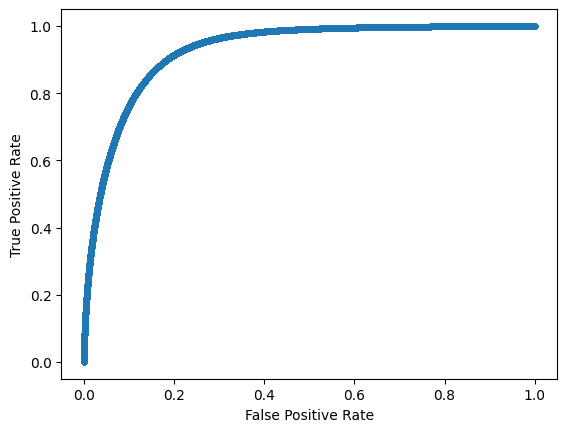

In [33]:
print(f'Validation accuracy is: {accuracy_score(y_test, prediction)}')

# Calculate roc metric 
print('Logistic : ROC AUC = %.3f' % (roc_auc_score(y_test,prediction_probab[:,1])))

fpr,tpr,_ = roc_curve(y_test,prediction_probab[:,1])
plt.plot(fpr,tpr,marker = '.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [34]:
# Clear the memory before loading the test data to predict
del(fpr,tpr)

In [35]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [38]:
# Original Accuracy
original_accuracy = accuracy_score(y_test, prediction)

# Calculate original roc metric
original_roc_auc = roc_auc_score(y_test, prediction_probab[:, 1])

# Calculate original Amex Score
y_pred = pd.DataFrame({
    'customer_id': C_test.customer_id,
    's_2': C_test.s_2,
    'target': y_test,
    'prediction': prediction_probab[:, 1]
}).sort_values(by=['customer_id', 's_2']).groupby('customer_id').agg('last')
original_amex_score = amex_metric(y_pred[['target']], y_pred[['prediction']])

print('Original Accuracy: %.5f, ROC AUC: %.5f, Amex: %.5f' %
      (original_accuracy, original_roc_auc, original_amex_score))

del y_pred


Original Accuracy: 0.86493, ROC AUC: 0.92782, Amex: 0.75226


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


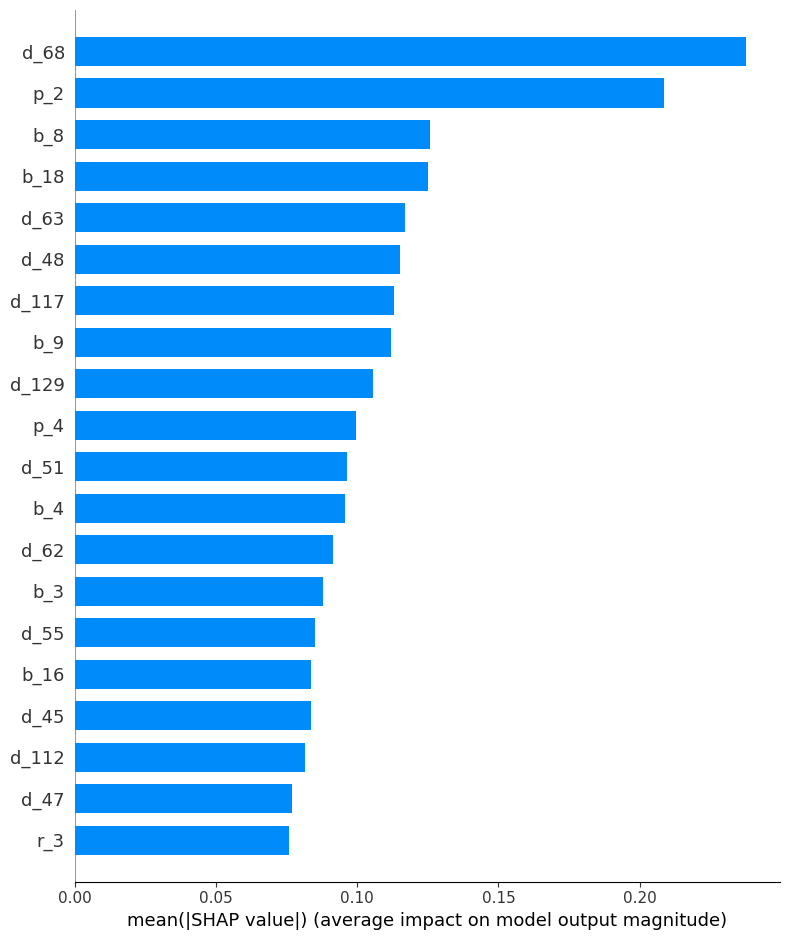

In [39]:
import shap

explainer = shap.LinearExplainer(logit2, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)

# Summarize the effect of all the features
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, plot_type='bar')

In [40]:
# Generate global shap values and associate with the column
global_shap_values = {k:v for k, v in sorted(zip(X_test.columns, np.abs(shap_values).mean(0)), reverse=False, key=lambda value: value[1])}
print(global_shap_values)

{'r_18': 2.7551934e-05, 'r_24': 0.00018015565, 'r_23': 0.00021869536, 'd_109': 0.00037420707, 'b_26': 0.00039391057, 'r_14': 0.00039750792, 'r_25': 0.00045091924, 'b_12': 0.00070427055, 'r_22': 0.0007408659, 's_16': 0.0011860062, 'd_82': 0.0013097456, 'd_108': 0.001461243, 'b_32': 0.0014879447, 'b_31': 0.0016136746, 's_23': 0.0016397132, 'd_94': 0.0021046721, 'r_6': 0.0021596225, 'd_89': 0.0023203245, 'r_20': 0.0024744547, 'b_13': 0.0025858148, 'b_21': 0.0027763322, 's_26': 0.0030868414, 's_19': 0.0035798582, 's_17': 0.0042664954, 'r_19': 0.0047471775, 'd_140': 0.004763219, 'd_65': 0.0047714193, 'b_6': 0.0049112304, 'r_16': 0.004926365, 'b_41': 0.0057139774, 'd_71': 0.005791282, 'd_93': 0.005973977, 'd_120': 0.0060483497, 's_20': 0.006063055, 'b_30': 0.0064443136, 's_5': 0.006796408, 'd_125': 0.0068711694, 'd_145': 0.006950421, 'b_24': 0.007154493, 'b_5': 0.0074105547, 's_18': 0.007475224, 'r_21': 0.0081052, 'd_86': 0.009101372, 'd_96': 0.009160086, 'b_36': 0.009235506, 'd_78': 0.00944

## Feature Reduction using SHAP

In [42]:
cols_to_remove = []

# Initialize with scores from all columns
max_accuracy, max_roc_auc, max_amex_score = original_accuracy, original_roc_auc, original_amex_score

# Train/Test dropping one feature at a time
i = 0
for col, _ in global_shap_values.items():
    i += 1

    X_train_reduced = X_train.drop(columns=cols_to_remove + [col])
    X_test_reduced = X_test.drop(columns=cols_to_remove + [col])

    # Model
    logit2_reduced = LogisticRegression(
        solver='saga', random_state=2303, n_jobs=12).fit(X_train_reduced, y_train)

    y_pred_reduced = logit2_reduced.predict(X_test_reduced)
    y_pred_proba_reduced = logit2_reduced.predict_proba(X_test_reduced)

    # Calculate scores for this iteration
    accuracy = accuracy_score(y_test, y_pred_reduced)
    roc_auc = roc_auc_score(y_test, y_pred_proba_reduced[:, 1])
    y_pred = pd.DataFrame({
        'customer_id': C_test.customer_id,
        's_2': C_test.s_2,
        'target': y_test,
        'prediction': y_pred_proba_reduced[:, 1]
    }).sort_values(by=['customer_id', 's_2']).groupby('customer_id').agg('last')
    amex_score = amex_metric(y_pred[['target']], y_pred[['prediction']])

    print('-------------------------------Iteration %d------------------------' % i)
    print('Cols Dropped: ', cols_to_remove + [col])

    diff = accuracy - max_accuracy
    percent_diff = diff / max_accuracy
    print('Max Accuracy: %.5f, Current Accuracy: %.5f, Difference: %.5f, Percentage Diff: %.5f' % (
        max_accuracy, accuracy, diff, percent_diff))
    max_accuracy = max(max_accuracy, accuracy)

    diff = roc_auc - max_roc_auc
    percent_diff = diff / max_roc_auc
    print('Max ROC AUC: %.5f, Current ROC AUC: %.5f, Difference: %.5f, Percentage Diff: %.5f' % (
        max_roc_auc, roc_auc, diff, percent_diff))
    max_roc_auc = max(max_roc_auc, roc_auc)

    diff = amex_score - max_amex_score
    percent_diff = diff / max_amex_score
    print('Max Amex Score: %.5f, Current Amex Score: %.5f, Difference: %.5f, Percentage Diff: %.5f' % (
        max_amex_score, amex_score, diff, percent_diff))
    max_amex_score = max(max_amex_score, amex_score)

    # If the accuracy increases after dropping the column
    # then drop the column
    if diff <= -0.001:
        break

    cols_to_remove.append(col)


-------------------------------Iteration 1------------------------
Cols Dropped:  ['r_18']
Max Accuracy: 0.86493, Current Accuracy: 0.86492, Difference: -0.00001, Percentage Diff: -0.00001
Max ROC AUC: 0.92782, Current ROC AUC: 0.92782, Difference: -0.00000, Percentage Diff: -0.00000
Max Amex Score: 0.75226, Current Amex Score: 0.75231, Difference: 0.00005, Percentage Diff: 0.00006
-------------------------------Iteration 2------------------------
Cols Dropped:  ['r_18', 'r_24']
Max Accuracy: 0.86493, Current Accuracy: 0.86495, Difference: 0.00002, Percentage Diff: 0.00003
Max ROC AUC: 0.92782, Current ROC AUC: 0.92782, Difference: 0.00000, Percentage Diff: 0.00000
Max Amex Score: 0.75231, Current Amex Score: 0.75238, Difference: 0.00007, Percentage Diff: 0.00010
-------------------------------Iteration 3------------------------
Cols Dropped:  ['r_18', 'r_24', 'r_23']
Max Accuracy: 0.86495, Current Accuracy: 0.86492, Difference: -0.00003, Percentage Diff: -0.00003
Max ROC AUC: 0.92782,

In [43]:
# Prepare final reduced model
X_train_reduced = X_train.drop(columns=cols_to_remove)
X_test_reduced = X_test.drop(columns=cols_to_remove)

# Model
logit2_reduced = LogisticRegression(
    solver='saga', random_state=2303, n_jobs=12).fit(X_train_reduced, y_train)

y_pred_reduced = logit2_reduced.predict(X_test_reduced)
y_pred_proba_reduced = logit2_reduced.predict_proba(X_test_reduced)

In [46]:
def execute_model(df):
    # Just add extra columns with 0 value so that pipeline does not fail --> these are the extra columns that we had in the training data
    extra_cols = ['target']
    # Concatenate the dataframe of extra columns with the dataframe of the test data
    df = pd.concat([
        df,
        pd.DataFrame(
            np.zeros((df.shape[0], len(extra_cols))), columns=extra_cols)
    ], axis=1)

    # Use the pipeline to transform
    X = pipeline.transform(df)

    # Drop target & the insignificant variables found during the training using statsmodel p-value
    X.drop(columns=['target', 'customer_id', 's_2'] + df_vif[df_vif['VIF'] > 11]['feature'].to_list()
           + high_pval_col.tolist() + cols_to_remove, inplace=True)

    # return log_reg.predict(X), log_reg.predict_proba(X)
    # In the statsmodel predict will give the probability
    return logit2_reduced.predict_proba(X)[:,1]


In [47]:
# del (sm_logit1)
df_test = pd.read_parquet('../data/test.parquet')
df_test.columns = df_test.columns.str.lower()
# Define the result mdf
mdf = pd.DataFrame(columns=['customer_id', 's_2', 'proba'])
y_proba = execute_model(df_test)

mdf = pd.concat([
    mdf,
    pd.DataFrame({
        'customer_id': df_test['customer_id'].values,
        's_2': df_test['s_2'].values,
        'proba': y_proba
    })
])
mdf.to_csv(
    '../ignore/final/logistic_vif_shap/logisticregression_baseline_prediction.csv', index=False)


In [48]:
mdf['s_2'] = pd.to_datetime(mdf['s_2'])
mdf['s_2'].dtype

dtype('<M8[ns]')

## Just take the last statement probability of each customer

In [49]:
# Get the last statement probability of each of the customer
df_result_last = mdf.sort_values(by = 's_2').groupby('customer_id')[['customer_id','proba']].tail(1)
df_result_last.rename(columns= {'proba' : 'prediction'},inplace=True)
df_result_last.head()
df_result_last.to_csv('../ignore/final/logistic_vif_shap/logistic_baseline_laststmt_submission.csv', index=False)